**Portfolio: Zillow’s Home Value Prediction**

This portfolio project includes data cleanning, feature engineering, and modelling on the kaggle's Zillow’s Home Value Prediction competition data,  which contains real estate transactions information for three counties (Los Angeles, Orange and Ventura, California) in 2016. The dataset can be found here https://www.kaggle.com/c/zillow-prize-1/data.

Goal: To predict the the difference between the actual price and the estimate of the price by Zillow(Zestimate).

Results: Fine tuned XGBoost Model which reduced cross validation MAE to 0.068110.

Future Work: 
1. Feature Engineering more time series features
2. Employ more types of models such as decision tree to imrpove explanality
3. Identify listings with high estimate error by Zillow and see if there is any pattern to be captured. 
4. Integrate with other openly available datasets to enrich information. For example, to add average neibourhood income




In [1]:
# Read in Data

import numpy as np
import pandas as pd
zillow2016_data = pd.read_csv("/Users/ivan/Downloads/properties_2016.csv")

zillow2016_train_data = pd.read_csv("/Users/ivan/Downloads/train_2016_v2.csv")

Merged_2016 = pd.merge(zillow2016_train_data,
                 zillow2016_data,
                 on='parcelid', 
                 how='left')


/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# Data Cleaning and Feature Engineering

# -Feature Encoding
Merged_2016.loc[Merged_2016['hashottuborspa'] == True, 'hashottuborspa'] = 1
Merged_2016.loc[Merged_2016['hashottuborspa'].isnull(), 'hashottuborspa'] = 0

Merged_2016.loc[Merged_2016['taxdelinquencyflag'] == 'Y', 'taxdelinquencyflag'] = 1
Merged_2016.loc[Merged_2016['taxdelinquencyflag'].isnull(), 'taxdelinquencyflag'] = 0

Merged_2016['fireplaceflag'] = 0
Merged_2016.loc[~(Merged_2016['fireplacecnt'].isnull()), 'fireplaceflag'] = 1

Merged_2016['poolflag'] = 0
Merged_2016.loc[~(Merged_2016['poolcnt'].isnull()), 'poolflag'] = 1

Merged_2016.loc[Merged_2016['garagetotalsqft'].isnull(), 'garagetotalsqft'] = 0

Merged_2016.loc[Merged_2016['threequarterbathnbr'].isnull(), 'threequarterbathnbr'] = 0
Merged_2016.loc[Merged_2016['fullbathcnt'].isnull(), 'fullbathcnt'] = 0

# -Group Cities with less 500 transaction volume as Other for dummy encoding 
counts = Merged_2016['regionidcity'].value_counts()
mask = Merged_2016['regionidcity'].isin(counts[counts < 500].index)
Merged_2016['regionidcity'][mask] = 'Other'

# -Create feature Age from yearbuilt 
Merged_2016['Age'] = 2016 - Merged_2016['yearbuilt']
Merged_2016.loc[Merged_2016['heatingorsystemtypeid'].isnull(), 'heatingorsystemtypeid'] = 2

# -Create a list of columns to remove (with high more than 50% of missing values)
dt_df = Merged_2016.dtypes.reset_index()
dt_df.columns = ['column name', 'column data type']
numeric_columns = dt_df.loc[dt_df['column data type'] == 'float64', 'column name'].to_list()
non_missing_ratio_df = ((~Merged_2016[numeric_columns].isnull()).sum()/\
                        Merged_2016[numeric_columns].shape[0]).reset_index()

non_missing_ratio_df.columns = ['column name', 'non_null_ratio']
columns_to_remove = non_missing_ratio_df.loc[non_missing_ratio_df['non_null_ratio'] < 0.5, 'column name'].tolist()

# -Convert date string to dae 
Merged_2016['transactiondate'] = pd.to_datetime(Merged_2016['transactiondate'], format="%Y-%m-%d")

# -Create feature Month
Merged_2016['month'] = pd.DatetimeIndex(Merged_2016['transactiondate']).month


/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
# Dummy Encoding
def Create_Dummies(df, col_name_list):
    for i in col_name_list:
        X = pd.get_dummies(df[i],prefix=i, drop_first=True)
        df = pd.concat([df, X], axis=1)
    return df

dummie_columns = ['regionidcounty', 'propertylandusetypeid','heatingorsystemtypeid', 'regionidcity', 'month']


Merged_2016 = Create_Dummies(Merged_2016, dummie_columns)
Merged_2016.drop(dummie_columns, axis=1, inplace=True) 

In [10]:
# Standarlizing Independent variables
X = Merged_2016.drop(['logerror'], axis=1) 
y = Merged_2016['logerror']

# -Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2,
random_state=123)


# -Imputating missing values

from fancyimpute import IterativeImputer
                                                   
MICE_imputer = IterativeImputer()

X_train_inpute = X_train[['landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount', 
'structuretaxvaluedollarcnt', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'Age']]
X_train.loc[:, ['landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount', 
'structuretaxvaluedollarcnt', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'Age']] = \
MICE_imputer.fit_transform(X_train_inpute)

X_test_inpute = X_test[['landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount', 
'structuretaxvaluedollarcnt', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'Age']]
X_test.loc[:, ['landtaxvaluedollarcnt', 'taxvaluedollarcnt', 'taxamount', 
'structuretaxvaluedollarcnt', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'Age']] = \
MICE_imputer.fit_transform(X_test_inpute)


/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
# Drop Column not to use for modelling
X_train.drop(columns_to_remove, axis=1, inplace=True) 
X_train.drop(['transactiondate', 'propertycountylandusecode', 'propertyzoningdesc', 'parcelid',
                       'buildingqualitytypeid', 'yearbuilt', 'fips', 'censustractandblock', 'unitcnt', 
                        'roomcnt', 'regionidzip', 'rawcensustractandblock', 
                        'latitude', 'longitude', 'calculatedbathnbr', 'parcelid', 
                        'finishedsquarefeet12','bathroomcnt'], axis=1, inplace=True) 

X_test.drop(columns_to_remove, axis=1, inplace=True) 
X_test.drop(['transactiondate', 'propertycountylandusecode', 'propertyzoningdesc', 'parcelid',
                       'buildingqualitytypeid', 'yearbuilt', 'fips', 'censustractandblock', 'unitcnt', 
                        'roomcnt', 'regionidzip', 'rawcensustractandblock', 
                        'latitude', 'longitude', 'calculatedbathnbr', 'parcelid', 
                        'finishedsquarefeet12','bathroomcnt'], axis=1, inplace=True) 

# Normalize dependent variables
from sklearn.preprocessing import StandardScaler

def feature_scaling(X):
    '''Feature scaled data based on standardization'''
    sc = StandardScaler()
    X_std = sc.fit_transform(X)
    return pd.DataFrame(X_std, index=X.index, columns=X.columns)
X_train = feature_scaling(X_train)
X_test = feature_scaling(X_test)

/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
# Perform Grid Search on XGboost model parameters
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV

housing_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
gbm_param_grid = {'learning_rate': [0.01,0.1,0.5,0.9],
'n_estimators': [200],
'subsample': [0.3, 0.5, 0.9]}
gbm = xgb.XGBRegressor() 
grid_mse = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,
scoring='neg_mean_squared_error', cv=4, verbose=1) 
grid_mse.fit(X_train, y_train)
print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 30.5min finished


Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.9}
Lowest RMSE found:  0.16321224797366632


In [22]:
# Perform Randomized Search on XGboost model parameters
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import RandomizedSearchCV


housing_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
gbm_param_grid = {'learning_rate': np.arange(0.05,1.05,.05),
'n_estimators': [200],
'colsample_bytree':[0.25, 0.5, 0.75],
'subsample': np.arange(0.05,1.05,.05),
'max_depth':[2, 5, 8]}
gbm = xgb.XGBRegressor()
randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid,
n_iter=60, scoring='neg_mean_absolute_error', cv=4, verbose=1)
randomized_mse.fit(X_train, y_train)
print("Best parameters found: ",randomized_mse.best_params_)
#print("Lowest mae found: ", randomized_mse.best_score_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 60 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 55.8min finished


Best parameters found:  {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.15000000000000002, 'colsample_bytree': 0.25}
Lowest RMSE found:  0.26183613734531247


In [24]:
# Tune regularization term L1 for XGBoost model

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params={"objective":"reg:squarederror",'colsample_bytree': 0.5, 'subsample':0.9,
'learning_rate': 0.05,"max_depth":5}

l1_params = [2,5,8]
mae_l1=[]
for reg in l1_params:
    params["alpha"] = reg
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params,nfold=4,
                        num_boost_round=200,metrics="mae",as_pandas=True,seed=123)
    
    mae_l1.append(cv_results["test-mae-mean"].tail(1).values[0])
print("Best mae as a function of l1:")
print(pd.DataFrame(list(zip(l1_params,mae_l1)), columns=["l1","mae"]))

Best mae as a function of l1:
   l1       mae
0   2  0.068660
1   5  0.068456
2   8  0.068383


In [25]:
#Final Model Cross-Validation Performance
import pandas as pd
import xgboost as xgb
import numpy as np

housing_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
tuned_params = {"objective":"reg:squarederror",'colsample_bytree': 0.5, 'subsample':0.95,
'learning_rate': 0.05, 'max_depth': 2, 'alpha':8}
tuned_cv_results_rmse = xgb.cv(dtrain=housing_dmatrix,
params=tuned_params, nfold=4, num_boost_round=200, metrics="mae",
as_pandas=True, seed=123)
print("Tuned mae: %f" %((tuned_cv_results_rmse["test-mae-mean"]).tail(1)))


Tuned mae: 0.068186


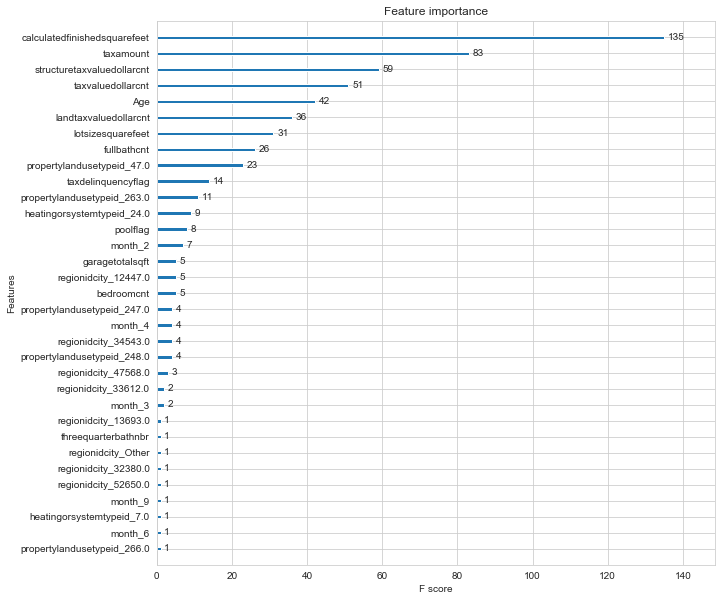

In [26]:
#Plot Feature Importance
import matplotlib.pyplot as plt
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
params = {'objective':'reg:squarederror', 'colsample_bytree': 0.5, 'subsample':0.9,
'learning_rate': 0.05, "max_depth":2}
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=200)
ax = xgb.plot_importance(xg_reg)
fig = ax.figure
fig.set_size_inches(10, 10)
plt.show()


In [27]:
#Validate Model on the Test set
eval_set = [(X_train, y_train), (X_test, y_test)]

xg_reg = xgb.XGBRegressor(booster='gbtree',
                          objective ='reg:squarederror',
                          max_depth = 2,
                          n_estimators = 200,
                          learning_rate = 0.05,
                          seed = 1)


xg_reg.fit(X_train,y_train, eval_metric="mae", eval_set = eval_set, verbose = True)

y_pred = xg_reg.predict(X_test)

[0]	validation_0-mae:0.47300	validation_1-mae:0.47241
[1]	validation_0-mae:0.45025	validation_1-mae:0.44964
[2]	validation_0-mae:0.42867	validation_1-mae:0.42805
[3]	validation_0-mae:0.40819	validation_1-mae:0.40759
[4]	validation_0-mae:0.38880	validation_1-mae:0.38819
[5]	validation_0-mae:0.37040	validation_1-mae:0.36981
[6]	validation_0-mae:0.35298	validation_1-mae:0.35240
[7]	validation_0-mae:0.33648	validation_1-mae:0.33589
[8]	validation_0-mae:0.32086	validation_1-mae:0.32026
[9]	validation_0-mae:0.30606	validation_1-mae:0.30544
[10]	validation_0-mae:0.29204	validation_1-mae:0.29142
[11]	validation_0-mae:0.27879	validation_1-mae:0.27817
[12]	validation_0-mae:0.26623	validation_1-mae:0.26561
[13]	validation_0-mae:0.25435	validation_1-mae:0.25376
[14]	validation_0-mae:0.24311	validation_1-mae:0.24255
[15]	validation_0-mae:0.23250	validation_1-mae:0.23194
[16]	validation_0-mae:0.22245	validation_1-mae:0.22192
[17]	validation_0-mae:0.21295	validation_1-mae:0.21244
[18]	validation_0-ma

[149]	validation_0-mae:0.06800	validation_1-mae:0.06772
[150]	validation_0-mae:0.06800	validation_1-mae:0.06772
[151]	validation_0-mae:0.06799	validation_1-mae:0.06772
[152]	validation_0-mae:0.06799	validation_1-mae:0.06772
[153]	validation_0-mae:0.06799	validation_1-mae:0.06772
[154]	validation_0-mae:0.06799	validation_1-mae:0.06772
[155]	validation_0-mae:0.06798	validation_1-mae:0.06772
[156]	validation_0-mae:0.06799	validation_1-mae:0.06772
[157]	validation_0-mae:0.06798	validation_1-mae:0.06772
[158]	validation_0-mae:0.06798	validation_1-mae:0.06772
[159]	validation_0-mae:0.06798	validation_1-mae:0.06772
[160]	validation_0-mae:0.06798	validation_1-mae:0.06772
[161]	validation_0-mae:0.06798	validation_1-mae:0.06772
[162]	validation_0-mae:0.06798	validation_1-mae:0.06772
[163]	validation_0-mae:0.06797	validation_1-mae:0.06772
[164]	validation_0-mae:0.06797	validation_1-mae:0.06772
[165]	validation_0-mae:0.06797	validation_1-mae:0.06772
[166]	validation_0-mae:0.06797	validation_1-mae: